In [1]:
import numpy as np
import matplotlib.pyplot as plt
import EPOS

First, initialize epos with the Kepler survey data

In [2]:
epos= EPOS.classes.epos(name='pfm',survey='Kepler')


 |~| epos 3.0.1.dev1 |~|


Using random seed 1465987992

Survey: Kepler-Gaia all dwarfs, reliability > 0.9


Generate some random data in the same format as the outcome of a planet formation model. 

In [3]:
# planets_per_system= 8
# n_stars= 77
# n_planets= n_stars*planets_per_system
# sma= 10.**np.random.uniform(-1.3,0.3,n_planets) # au
# mass= 10.** (3.*np.random.power(0.5, n_planets)) #earth mass
# radius= 10.** np.random.power(0.5, n_planets) # earth radii
# inc= np.random.rayleigh(2, n_planets) # degrees
# starID= np.repeat(np.arange(n_stars), planets_per_system) # unique identifier for each star, can be any type

# epos.set_population('Planet Formation Model', sma=sma, mass=mass, radius=radius, inc=inc, starID=starID)

A different set with two planetary systems

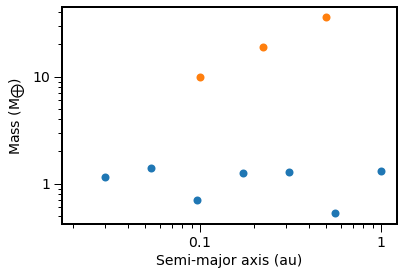

In [4]:
# system 1
sma1= np.geomspace(0.03,1,7)
mass1= 10.**np.random.normal(0,0.2, sma1.size)
inc1= np.random.rayleigh(0.5, sma1.size) # degrees

# system 2
sma2= np.geomspace(0.1,0.5,3)
mass2= 10.* (sma2/0.1)**0.8
inc2= np.random.rayleigh(3, sma2.size) # degrees


plt.scatter(sma1, mass1)
plt.scatter(sma2, mass2)
plt.loglog()
plt.xlabel('Semi-major axis (au)')
plt.ylabel('Mass (M$_\\bigoplus$)')
plt.show()

Now construct a single array for each variable

In [5]:
sma= np.concatenate( [sma1, sma2])
mass= np.concatenate( [mass1, mass2])
inc= np.concatenate( [inc1, inc2])
starID= np.concatenate([ ['system 1']* sma1.size, ['system2']*sma2.size])

Then the planet formaton model into EPOS

In [6]:
epos.set_population('Planet Formation Model', sma=sma, mass=mass, inc=inc, starID=starID)


  0 singles, 2 multis
  - single: 0
  - double: 0
  - triple: 1
  - quad: 0
  - quint: 0
  - sext: 0
  - sept: 1


We also need to tell EPOS to use a mass-radius relation to calculate planet radii

In [7]:
epos.set_massradius(EPOS.massradius.CK17, 'Chen & Kipping 2017', masslimits=[0.1,100])


Mass-Radius relation from Chen & Kipping 2017
Mass and Radius limits:
  min M = 0.100-> <R> =0.52
  max M = 100-> <R> =12.2


Run epos once to intialize some variables

In [8]:
EPOS.run.once(epos)


Preparing EPOS run...
  Set eta to default 0.3
  Set f_cor to default 0.5
  Set f_iso to default 0.5
  Set f_inc to default 1.0
  Set f_dP to default 1.0

Starting the first MC run
Finished one MC in 0.194 sec


Calculate planet occurrence rates

In [9]:
#EPOS.occurrence.all(epos, Verbose=False)
#EPOS.occurrence.planets(epos)
EPOS.occurrence.models(epos)
#list(epos.occurrence['model'])


Interpolating model planet occurrence


Now we can plot all the survey detection efficiency and all the different components that go into the survey completeness:
- Transit Probability
- Detection Efficiency
- Vetting Efficiency

In [10]:
def contour_completeness(epos, key, title, levels= [1e-3, 0.01, 0.1, 0.5, 0.9] ):
    plt.loglog()
    plt.title(title)
    plt.xlabel('Period (day)')
    plt.ylabel('Radius ($R_\\bigoplus$)')

    toplot= getattr(epos, key)
    cs= plt.contour(epos.eff_xvar, epos.eff_yvar, toplot.T, colors='k', levels=levels)
    fmt_percent= lambda x: '{:g} %'.format(100.*x)
    plt.clabel(cs, cs.levels, inline=True, fmt=fmt_percent)

        
    im= plt.scatter(epos.pfm['P'], epos.pfm['R'], c=epos.occurrence['model'][key], 
                cmap='jet')
    plt.colorbar(im)
    plt.show()

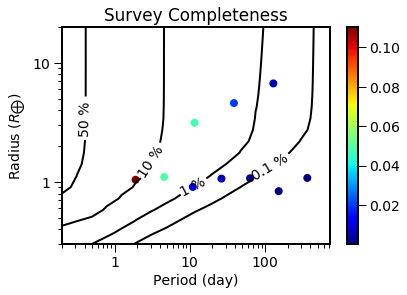

In [11]:
contour_completeness(epos, key= 'completeness', title='Survey Completeness', 
                     levels= [1e-3, 0.01, 0.1, 0.5, 0.9])

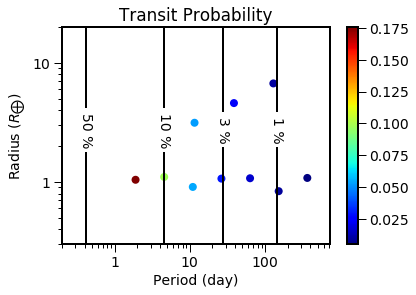

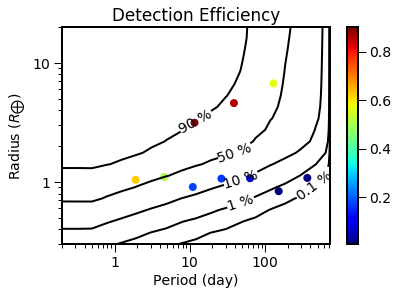

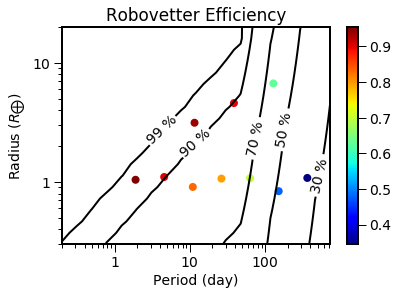

In [12]:
contour_completeness(epos, key= 'fgeo', title='Transit Probability', 
                     levels= [1e-3, 3e-3, 0.01, 0.03, 0.1, 0.5])
contour_completeness(epos, key= 'eff_2D', title='Detection Efficiency', 
                     levels= [1e-3, 0.01, 0.1, 0.5, 0.9])
contour_completeness(epos, key= 'vetting', title='Robovetter Efficiency', 
                     levels= [0.1, 0.3, 0.5, 0.7, 0.9, 0.99])

In [13]:
EPOS.save.to_csv('survey_completeness',
    star= epos.pfm['ID'], planet_ID= epos.pfm['order'],
    period_day=epos.pfm['P'], radius_earth=epos.pfm['R'], 
    transit_probability= epos.occurrence['model']['fgeo'], 
    detection_efficiency= epos.occurrence['model']['eff_2D'],
    vetting_efficiency=epos.occurrence['model']['vetting'], 
    combined_completeness= epos.occurrence['model']['completeness'])